Library imports

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.io import savemat


from Toolbox_GCSR.Preprocessing import Processor
from sklearn.preprocessing import minmax_scale
from Toolbox_GCSR.utility import eval_band, eval_band_cv
from Toolbox_GCSR.EGCSR_BS_Ranking import EGCSR_BS_Ranking

from Toolbox_bombs.runner import main
from Toolbox_bombs.utils import Arguments

import matlab.engine
eng = matlab.engine.start_matlab()

eng.addpath(eng.genpath("Toolbox_SVD"));
eng.addpath(eng.genpath("Toolbox_OCF"));

Data Importation and adequation

In [2]:
root = 'D:\Python\HSI_Files\\'
#im_, gt_ = 'CornData', 'CornLabels'
datasetName = "Corn2021No100"
im_, gt_ = 'CornDataNo100', 'CornLabelsNo100'

hsi_path = {'img_path': root + im_ + '.mat', 'gt_path': root + gt_ + '.mat'}


#img_path = root + im_ + '.mat'
#gt_path = root + gt_ + '.mat'


Parameters and variables

In [19]:
#dictionary for subsets selected from all algorithms
bands_selected = {}

#The number of iterations and number of selecte bands
iter = 8
factor = 4
#each algorithm will select bands for each iter*factor number of bands


# Band selection algorithms definition and configuration

SVD Algorithm

In [34]:
def svd(hsi_path, band_num):

    data_m = eng.double(eng.importdata(hsi_path['img_path']))

    select_svd = eng.svd_function(data_m, band_num);

    bands = np.array(select_svd)

    bands = bands.reshape(1,band_num)

    bands = bands[0]

    bands = bands - 1
    
    return bands

OCF Algorithm

In [35]:

def ocf(hsi_path, band_num):

    data_m = eng.double(eng.importdata(hsi_path['img_path']))

    select_ocf = eng.ocf_trc_fdpc(data_m, band_num);

    bands = np.array(select_ocf)

    bands = bands.reshape(1,band_num)

    bands = bands[0]

    bands = bands - 1

    return bands

BOMBS Algorithm

In [36]:
RESULTS_DIR = os.path.join(
    os.getenv("Bombs_results", os.path.join("..", "..", "results")),
    "bombs_band_selection"
)

def bombs(hsi_path, bands_num):

    arguments = Arguments(
            bands_per_antibody=bands_num,
            data_path = hsi_path['img_path'],
            ref_map_path=hsi_path['gt_path'],
            dest_path=RESULTS_DIR,
            Gmax=6,
            Na=10,
            Nd=25,
            Nc=25,
            TD_size=30,
            P_init_size=100,
        )
    return main(args=arguments)

GCSR Algorithm

In [37]:
#
def EGCSR(hsi_path, bands_num):

    p = Processor()
    hsi_data, _ = p.prepare_data(hsi_path['img_path'], hsi_path['gt_path'])

    alg_Ranking = EGCSR_BS_Ranking(bands_num, regu_coef=1e2, n_neighbors=3, ro=0.8)
    alg_Ranking.predict(hsi_data)
    return alg_Ranking.band_indx


Algorithms to be used in selection

In [38]:
BS_functions = []
BS_functions.append(EGCSR)
BS_functions.append(bombs)
BS_functions.append(svd)
BS_functions.append(ocf)


band selectrion process

In [39]:
for alg in BS_functions:

    bands_selected[alg.__name__] = np.zeros((iter,factor*iter)).astype(int)

    print(alg.__name__ + ' START')
    for i in range(iter):
        band_count = (i+1)*factor

        alg_bands = alg(hsi_path, band_count)

        bands_selected[alg.__name__][i,:len(alg_bands)] = alg_bands.astype(int)

    
    print(alg.__name__ + ' ENDS')

    print(bands_selected)

EGCSR START
band index: [ 891  890  889 1248]
band indexlength: 4
band index: [ 893  887  892  888  891  890  889 1248]
band indexlength: 8
band index: [ 885  895  894  886  893  887  892  888  891  890  889 1248]
band indexlength: 12
band index: [ 883  897  884  896  885  895  894  886  893  887  892  888  891  890
  889 1248]
band indexlength: 16
band index: [ 900  882  899  898  883  897  884  896  885  895  894  886  893  887
  892  888  891  890  889 1248]
band indexlength: 20
band index: [ 416  415  413  414  900  882  899  898  883  897  884  896  885  895
  894  886  893  887  892  888  891  890  889 1248]
band indexlength: 24
band index: [ 419  418  417  412  416  415  413  414  900  882  899  898  883  897
  884  896  885  895  894  886  893  887  892  888  891  890  889 1248]
band indexlength: 28
band index: [ 421  410  420  411  419  418  417  412  416  415  413  414  900  882
  899  898  883  897  884  896  885  895  894  886  893  887  892  888
  891  890  889 1248]
band 

In [40]:
#saves selected bands
#savemat(datasetName, bands_selected)

# Classification

In [46]:
# classification and visualizarion imports
import utils
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [42]:
#Classification algorithms to use

#Creates RandomForest Clasiffier
RF = RandomForestClassifier(max_depth=6, random_state=0)

#Creates Svm Clasiffier
SVM = svm.SVC(C = 100, kernel = 'poly', degree = 2, cache_size = 10*1024)

#Creates Multi-Leyer perceptron classifier
MLP = MLPClassifier(hidden_layer_sizes=(100,200,50,20), activation='relu', solver='adam', max_iter=1000)


In [43]:
#Data and labels
Data = loadmat(hsi_path['img_path'])['Data']
Labels = loadmat(hsi_path['gt_path'])['Labels']

Classifiers = []
Classifiers.append(RF)
Classifiers.append(SVM)
Classifiers.append(MLP)

Accuracy_values = {}

In [44]:
#Iterates over bands sets 
for alg in bands_selected:      

    for i in range(iter):

        #number of bands in current iteration
        b_count = (i+1)*factor

        #takes selected bands from dataset
        DataSelected = Data[:,bands_selected[alg][i,0:b_count]]

        #Prints bands to process
        print("Processing: ", alg, b_count)

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(DataSelected, Labels,
                                                            test_size=0.15, random_state=11, stratify = Labels)

        for C in Classifiers:
        
            alg_bands = C.fit(X_train, y_train.ravel())

            #Prediction of test set using trained model
            test_prediction = C.predict(X_test)

            accuracy = metrics.accuracy_score(y_test,test_prediction)

            print(C.__class__.__name__, "accuracy is: ", accuracy*100)


Processing:  EGCSR 4
RandomForestClassifier accuracy is:  54.90196078431373
SVC accuracy is:  56.86274509803921
MLPClassifier accuracy is:  58.82352941176471
Processing:  EGCSR 8
RandomForestClassifier accuracy is:  54.90196078431373
SVC accuracy is:  64.70588235294117
MLPClassifier accuracy is:  56.86274509803921
Processing:  EGCSR 12
RandomForestClassifier accuracy is:  50.98039215686274
SVC accuracy is:  68.62745098039215
MLPClassifier accuracy is:  58.82352941176471
Processing:  EGCSR 16
RandomForestClassifier accuracy is:  50.98039215686274
SVC accuracy is:  68.62745098039215
MLPClassifier accuracy is:  58.82352941176471
Processing:  EGCSR 20
RandomForestClassifier accuracy is:  54.90196078431373
SVC accuracy is:  70.58823529411765
MLPClassifier accuracy is:  58.82352941176471
Processing:  EGCSR 24
RandomForestClassifier accuracy is:  58.82352941176471
SVC accuracy is:  70.58823529411765
MLPClassifier accuracy is:  60.78431372549019
Processing:  EGCSR 28
RandomForestClassifier acc

In [62]:
# Split dataset into training set and test set
PX_train, PX_test, Py_train, Py_test = train_test_split(Data[:,bands_selected["svd"][7,0:32]], Labels,
                                                            test_size=0.15, random_state=11, stratify = Labels)

In [63]:
steps = [('scaler',MinMaxScaler()),('classifier',RandomForestClassifier())]
pipe = Pipeline(steps)

n_estimators = [3,5,8,10]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 61, num = 20)]
min_samples_split = [4, 6, 8]
min_samples_leaf = [4, 7, 10]
bootstrap = [True, False]

param_grid = dict(classifier__n_estimators = n_estimators,
                  classifier__max_features = max_features,
                  classifier__max_depth = max_depth,
                  classifier__min_samples_split = min_samples_split,
                  classifier__min_samples_leaf = min_samples_leaf,
                  classifier__bootstrap = bootstrap)

grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(PX_train,Py_train)

c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d arra

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [1, 4, 7, 10, 13, 16, 19, 23,
                                                   26, 29, 32, 35, 38, 42, 45,
                                                   48, 51, 54, 57, 61],
                         'classifier__max_features': ['auto', 'sqrt'],
                         'classifier__min_samples_leaf': [4, 7, 10],
                         'classifier__min_samples_split': [4, 6, 8],
                         'classifier__n_estimators': [3, 5, 8, 10]})

In [64]:
grid_search.best_params_

{'classifier__bootstrap': False,
 'classifier__max_depth': 57,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 4,
 'classifier__n_estimators': 8}

In [65]:
pipe.set_params(classifier__n_estimators = grid_search.best_params_['classifier__n_estimators'])
pipe.set_params(classifier__max_features = grid_search.best_params_['classifier__max_features'])
pipe.set_params(classifier__max_depth = grid_search.best_params_['classifier__max_depth'])
pipe.set_params(classifier__min_samples_split = grid_search.best_params_['classifier__min_samples_split'])
pipe.set_params(classifier__min_samples_leaf = grid_search.best_params_['classifier__min_samples_leaf'])
pipe.set_params(classifier__bootstrap = grid_search.best_params_['classifier__bootstrap'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=57,
                                        min_samples_leaf=7, min_samples_split=4,
                                        n_estimators=8))])

In [66]:
pipe.fit(PX_train,Py_train)

c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=57,
                                        min_samples_leaf=7, min_samples_split=4,
                                        n_estimators=8))])

c:\Users\marat\.conda\envs\ai\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


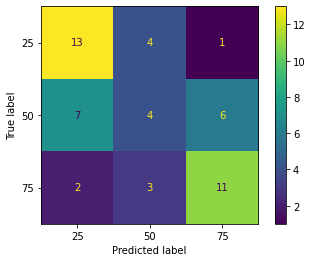

In [67]:
plot_confusion_matrix(pipe, PX_test, Py_test) 


In [69]:
y_est = pipe.predict(PX_test)
accuracy_score(Py_test,y_est)

0.5490196078431373